# DS 3000 - Assignment 10

**Student Name**: [Julia Ouritskaya]

**Date**: [11/11/2023]


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

## Assignment 10 (50 pts)

In this assignment, you will build a machine learning model to predict tip amount using the NYC Green Taxi Trip Records data for February 2020. Here is a link to the accompanying [data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf). Ensure that you explain each step and the results from each question. You are encouraged to include your previous data preparation steps from Assignment 4 as needed.

Data Source: https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet

Instructions: 

In this assignment, you will use the random forest algorithm to build a machine learning model that predicts the tip_amount. You will be working with a dataset that you are familiar with, and you will learn how to use the insights from EDA to guide your modeling decisions.

Write python code to answer the questions below and ensure that you round the result of all numeric calculations to 2 decimal places. 

## Question 1: (50 pts) 

Load the data directly from the URL into a DataFrame.

In [1]:
# Install the fast parquet library
!pip install fastparquet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# Load the data directly from the URL into a DataFrame
tripdata_df = pd.read_parquet(path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet',
                             engine = 'fastparquet')

## Question 2 (10 pts)

Include any previous data preparation steps, EDA and visualizations. It is ok to reuse your previous code from assignment 4. However, ensure that you update the code based on the previous feedback from the TAs. Also, address the following:
- Ensure that you delete any widespread missing data and handle negative dollar amounts. Justify your approach to handling negative amounts.
- The findings from your previous analysis would have indicated that most customers use green taxis to travel short distances. Therefore, ensure that you filter any outlier trips.

### Inspect the Data

In [4]:
# Inspect the data to identify its dimensions
tripdata_df.shape

(398632, 20)

The dataset has 398,632 observations (rows) and 20 variables (columns).

In [5]:
# Inspect the data to indicate if the variables have suitable types
tripdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398632 entries, 0 to 398631
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               398632 non-null  int64         
 1   lpep_pickup_datetime   398632 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  398632 non-null  datetime64[ns]
 3   store_and_fwd_flag     317739 non-null  object        
 4   RatecodeID             317739 non-null  float64       
 5   PULocationID           398632 non-null  int64         
 6   DOLocationID           398632 non-null  int64         
 7   passenger_count        317739 non-null  float64       
 8   trip_distance          398632 non-null  float64       
 9   fare_amount            398632 non-null  float64       
 10  extra                  398632 non-null  float64       
 11  mta_tax                398632 non-null  float64       
 12  tip_amount             398632 non-null  floa

- `store_and_fwd_flag` should be represented as a boolean.
- `RatecodeID`, `VendorID`, `passenger_count`, `payment_type`, and `trip_type` should be represented as integers instead of floats.

### Missing Values

In [6]:
# Evaluate the frequency of missing values
tripdata_df.isnull().sum()

VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        80893
RatecodeID                80893
PULocationID                  0
DOLocationID                  0
passenger_count           80893
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                398632
improvement_surcharge         0
total_amount                  0
payment_type              80893
trip_type                 80894
congestion_surcharge      80893
dtype: int64

Cells with significant missing data: `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `ehail_fee`, `payment_type`, `trip_type`, `congestion_surcharge`

In [7]:
# Evaluate if missing values are an isolated case or a widespread issue by counting the frequency of missing values in each row (i.e. how many columns are empty)
tripdata_df.isnull().sum(axis=1).sort_values(ascending = False)

398631    7
344706    7
344699    7
344700    7
344701    7
         ..
132875    1
132874    1
132873    1
132872    1
199316    1
Length: 398632, dtype: int64

The missing values are mainly widespread cases. 
- `ehail_fee`: Can be deleted as this column has all missing values.
- `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `payment_type`, `trip_type`, `congestion_surcharge`: Missing 7 column values; while it is not 50% of the data, there is too much missing data to repair and rows should be removed.

### Types of Data

Categorical data in the dataset:

1. `VendorID`: nominal – codes are either '1' or '2'
2. `RateCodeID`: nominal – codes are from '1' to '6' with no inherent order
3. `Store_and_fwd_flag`: nominal – codes are 'Y' or 'N'
4. `Payment_type`: nominal – codes range from credit card to voided trip
5. `Trip_type`: nominal – codes are '1' (street-hail) or '2' (dispatch)

### Invalid Data

In [8]:
# Null Values
tripdata_df['VendorID'].value_counts(dropna=False)

2    345899
1     52704
6        29
Name: VendorID, dtype: int64

There exist values in `VendorID` where the Vendor ID is not defined in the data dictionary.

In [9]:
# Questionable Values
tripdata_df['mta_tax'].value_counts(dropna=False)

 0.50    320898
 0.00     76663
-0.50      1070
 3.55         1
Name: mta_tax, dtype: int64

In [10]:
# Questionable Values
tripdata_df['extra'].value_counts(dropna=False)

 0.00     167861
 0.50      82457
 2.75      78612
 1.00      61106
 5.50       3878
 3.25       1980
 3.75       1751
-0.50        356
 8.25        276
-1.00        197
 4.50        125
 0.63          5
-4.50          3
 0.80          2
 0.68          1
 1.02          1
 1.46          1
 1.25          1
 1.11          1
 1.20          1
 2.94          1
 1.22          1
 0.86          1
 2.22          1
 0.76          1
 1.80          1
 1.08          1
 1.03          1
 2.03          1
 1.07          1
 2.52          1
 16.74         1
 1.81          1
 8.23          1
 2.20          1
 14.26         1
 0.66          1
Name: extra, dtype: int64

- `mta_tax`: $0.50 MTA tax that is automatically triggered based on the metered rate in use (other values displayed).
- `extra`: Miscellaneous extras and surcharges (should not be negative).

In [11]:
# Zero Distance
tripdata_df['trip_distance'].value_counts(dropna=False)

0.00     12993
1.00      3317
0.90      3313
0.80      3155
1.10      2968
         ...  
29.73        1
34.48        1
32.04        1
27.35        1
29.91        1
Name: trip_distance, Length: 3056, dtype: int64

In [12]:
tripdata_df[tripdata_df['trip_distance'] == 0.00]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
91,1,2020-02-01 00:29:37,2020-02-01 00:43:16,N,1.0,91,35,1.0,0.0,17.20,0.00,0.5,0.00,0.0,NaN,0.3,18.00,1.0,1.0,0.0
174,2,2020-02-01 00:52:05,2020-02-01 00:52:12,N,5.0,213,213,1.0,0.0,9.00,0.00,0.0,0.00,0.0,NaN,0.3,9.30,1.0,2.0,0.0
209,2,2020-02-01 00:08:04,2020-02-01 00:34:08,N,5.0,7,193,2.0,0.0,8.00,0.00,0.0,0.00,0.0,NaN,0.3,8.30,1.0,2.0,0.0
308,2,2020-02-01 00:50:04,2020-02-01 00:50:50,N,5.0,264,264,1.0,0.0,13.80,0.00,0.0,2.82,0.0,NaN,0.3,16.92,1.0,2.0,0.0
453,1,2020-02-01 00:31:26,2020-02-01 00:31:41,N,1.0,129,129,1.0,0.0,2.50,0.50,0.5,10.00,0.0,NaN,0.3,13.80,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397818,2,2020-02-29 14:22:00,2020-02-29 14:24:00,None,NaN,159,159,NaN,0.0,9.32,0.00,0.0,0.00,0.0,NaN,0.3,9.62,NaN,NaN,NaN
397922,2,2020-02-29 15:30:00,2020-02-29 15:54:00,None,NaN,167,213,NaN,0.0,19.24,2.75,0.0,0.00,0.0,NaN,0.3,22.29,NaN,NaN,NaN
398163,2,2020-02-29 17:41:00,2020-02-29 17:56:00,None,NaN,64,19,NaN,0.0,21.47,2.75,0.0,0.00,0.0,NaN,0.3,24.52,NaN,NaN,NaN
398266,2,2020-02-29 18:34:00,2020-02-29 19:03:00,None,NaN,82,121,NaN,0.0,39.95,2.75,0.0,0.00,0.0,NaN,0.3,43.00,NaN,NaN,NaN


There are around 12,000 instances of `trip_distance` being 0, which does not make sense so they should be removed.

In [13]:
# Negative Costs
tripdata_df[tripdata_df['total_amount'] < 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
225,2,2020-02-01 00:46:14,2020-02-01 00:48:00,N,1.0,77,77,1.0,0.43,-3.50,-0.50,-0.5,0.00,0.0,NaN,-0.3,-4.80,3.0,1.0,0.0
683,2,2020-02-01 01:32:39,2020-02-01 01:34:32,N,5.0,134,134,1.0,0.00,-25.00,0.00,0.0,0.00,0.0,NaN,0.0,-25.00,4.0,2.0,0.0
996,2,2020-02-01 02:45:38,2020-02-01 02:46:06,N,1.0,7,7,1.0,0.11,-2.50,-0.50,-0.5,0.00,0.0,NaN,-0.3,-3.80,3.0,1.0,0.0
1043,2,2020-02-01 02:42:26,2020-02-01 02:44:45,N,1.0,7,7,1.0,0.51,-4.00,-0.50,-0.5,0.00,0.0,NaN,-0.3,-5.30,3.0,1.0,0.0
1086,2,2020-02-01 02:05:00,2020-02-01 02:08:33,N,1.0,41,41,1.0,0.50,-4.50,-0.50,-0.5,0.00,0.0,NaN,-0.3,-5.80,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372143,2,2020-02-20 14:03:00,2020-02-20 14:28:00,None,NaN,185,168,NaN,5.59,-40.78,0.00,0.5,3.98,0.0,NaN,0.3,-36.00,NaN,NaN,NaN
372617,2,2020-02-20 16:06:00,2020-02-20 16:21:00,None,NaN,181,181,NaN,0.91,-32.91,2.75,0.0,0.00,0.0,NaN,0.3,-29.86,NaN,NaN,NaN
394865,2,2020-02-28 11:47:10,2020-02-28 11:50:00,None,NaN,242,242,NaN,0.13,-15.75,0.00,0.5,0.00,0.0,NaN,0.3,-15.25,NaN,NaN,NaN
396278,2,2020-02-28 18:13:00,2020-02-28 18:20:00,None,NaN,35,76,NaN,0.87,-46.05,2.75,0.0,0.00,0.0,NaN,0.3,-43.00,NaN,NaN,NaN


In [14]:
tripdata_df[tripdata_df['fare_amount'] < 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
225,2,2020-02-01 00:46:14,2020-02-01 00:48:00,N,1.0,77,77,1.0,0.43,-3.50,-0.50,-0.5,0.0,0.00,NaN,-0.3,-4.80,3.0,1.0,0.0
683,2,2020-02-01 01:32:39,2020-02-01 01:34:32,N,5.0,134,134,1.0,0.00,-25.00,0.00,0.0,0.0,0.00,NaN,0.0,-25.00,4.0,2.0,0.0
996,2,2020-02-01 02:45:38,2020-02-01 02:46:06,N,1.0,7,7,1.0,0.11,-2.50,-0.50,-0.5,0.0,0.00,NaN,-0.3,-3.80,3.0,1.0,0.0
1043,2,2020-02-01 02:42:26,2020-02-01 02:44:45,N,1.0,7,7,1.0,0.51,-4.00,-0.50,-0.5,0.0,0.00,NaN,-0.3,-5.30,3.0,1.0,0.0
1086,2,2020-02-01 02:05:00,2020-02-01 02:08:33,N,1.0,41,41,1.0,0.50,-4.50,-0.50,-0.5,0.0,0.00,NaN,-0.3,-5.80,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372617,2,2020-02-20 16:06:00,2020-02-20 16:21:00,None,NaN,181,181,NaN,0.91,-32.91,2.75,0.0,0.0,0.00,NaN,0.3,-29.86,NaN,NaN,NaN
393029,2,2020-02-27 18:49:00,2020-02-27 19:05:00,None,NaN,26,26,NaN,1.67,-0.91,2.75,0.0,0.0,13.75,NaN,0.3,15.89,NaN,NaN,NaN
394865,2,2020-02-28 11:47:10,2020-02-28 11:50:00,None,NaN,242,242,NaN,0.13,-15.75,0.00,0.5,0.0,0.00,NaN,0.3,-15.25,NaN,NaN,NaN
396278,2,2020-02-28 18:13:00,2020-02-28 18:20:00,None,NaN,35,76,NaN,0.87,-46.05,2.75,0.0,0.0,0.00,NaN,0.3,-43.00,NaN,NaN,NaN


`total_amount` and `fare_amount` have negative values which does not make sense so they should be removed. 

### Data Preparation

In [15]:
# Handling Missing/Null Values -- Deletion
tripdata_df = tripdata_df.drop(['ehail_fee'], axis=1)

In [16]:
tripdata_df.shape

(398632, 19)

In [17]:
# Handling Missing/Null Values -- Deletion (6 or more missing values)
tripdata_df = tripdata_df[tripdata_df.isnull().sum(axis=1) < 6]

In [18]:
tripdata_df.shape

(317739, 19)

In [19]:
tripdata_df = tripdata_df.dropna(subset = ['trip_type'])

In [20]:
tripdata_df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
dtype: int64

In [21]:
# Convert to suitable data types
tripdata_df['RatecodeID'] = tripdata_df['RatecodeID'].astype(int)
tripdata_df['VendorID'] = tripdata_df['VendorID'].astype(int)
tripdata_df['passenger_count'] = tripdata_df['passenger_count'].astype(int)
tripdata_df['payment_type'] = tripdata_df['payment_type'].astype(int)
tripdata_df['trip_type'] = tripdata_df['trip_type'].astype(int)

In [22]:
tripdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317738 entries, 0 to 317738
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               317738 non-null  int64         
 1   lpep_pickup_datetime   317738 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  317738 non-null  datetime64[ns]
 3   store_and_fwd_flag     317738 non-null  object        
 4   RatecodeID             317738 non-null  int64         
 5   PULocationID           317738 non-null  int64         
 6   DOLocationID           317738 non-null  int64         
 7   passenger_count        317738 non-null  int64         
 8   trip_distance          317738 non-null  float64       
 9   fare_amount            317738 non-null  float64       
 10  extra                  317738 non-null  float64       
 11  mta_tax                317738 non-null  float64       
 12  tip_amount             317738 non-null  floa

In [23]:
# Handle invalid fare amounts
tripdata_df = tripdata_df[tripdata_df['fare_amount'] > 0]

In [24]:
# Handle invalid trip distance
tripdata_df = tripdata_df[tripdata_df['trip_distance'] > 0]

In [25]:
tripdata_df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2020-02-01 00:10:25,2020-02-01 00:14:34,N,1,74,41,1,0.76,4.5,0.5,0.5,0.00,0.0,0.3,5.80,2,1,0.00
1,2,2020-02-01 00:16:59,2020-02-01 00:21:35,N,1,74,74,1,0.72,5.0,0.5,0.5,0.00,0.0,0.3,6.30,1,1,0.00
2,2,2020-02-01 00:19:31,2020-02-01 00:25:29,N,1,223,7,1,0.89,6.0,0.5,0.5,1.82,0.0,0.3,9.12,1,1,0.00
3,2,2020-02-01 00:43:52,2020-02-01 00:48:58,N,1,145,145,1,1.12,6.0,0.5,0.5,0.00,0.0,0.3,7.30,2,1,0.00
4,2,2020-02-01 00:32:53,2020-02-01 00:35:19,N,1,166,166,1,0.65,4.0,0.5,0.5,1.06,0.0,0.3,6.36,1,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317734,2,2020-02-29 23:21:09,2020-02-29 23:48:18,N,1,80,130,1,9.36,30.5,0.5,0.5,6.36,0.0,0.3,38.16,1,1,0.00
317735,2,2020-02-29 23:56:56,2020-03-01 00:01:25,N,5,42,42,1,0.90,8.0,0.0,0.0,0.00,0.0,0.3,8.30,2,2,0.00
317736,2,2020-02-29 22:55:32,2020-02-29 23:07:22,N,1,116,235,1,2.64,10.5,0.5,0.5,0.00,0.0,0.3,11.80,2,1,0.00
317737,2,2020-02-29 23:35:49,2020-02-29 23:37:22,N,1,74,74,1,0.03,3.0,0.5,0.5,0.00,0.0,0.3,4.30,2,1,0.00


I handled negative dollar amounts for `fare_amount` and `total_amount` by removing them. This is because a negative amount does not make sense in this context and does not represent typical trip costs. They could be an indicator of a refund or a data error. 

### Data Analysis

In [26]:
# Maximum and minimum fare amounts
max_fare = tripdata_df['total_amount'].max()
min_fare = tripdata_df['total_amount'].min()

# Most and least expensive trip
most_expensive_trip = tripdata_df[tripdata_df['total_amount'] == max_fare]
least_expensive_trip = tripdata_df[tripdata_df['total_amount'] == min_fare]

# Distance for most and least expensive trip
most_expensive_distance = most_expensive_trip['trip_distance'].iloc[0]  
least_expensive_distance = least_expensive_trip['trip_distance'].iloc[0]

# Print results
print(f"The most expensive trip is ${max_fare} and traveled for {most_expensive_distance} miles.")
print(f"The least expensive trip is ${min_fare} and traveled for {least_expensive_distance} miles.")


The most expensive trip is $651.5 and traveled for 1.1 miles.
The least expensive trip is $0.01 and traveled for 2.8 miles.


The results demonstrate that the most expensive trip is 651.50 with a distance of 1.1 miles while the least expensive trip is 0.01 with a distance of 2.8 miles. The most expensive trip seems very expensive for having only covered 1.1 miles, which could indicate anomalies in the data due to various reasons. 

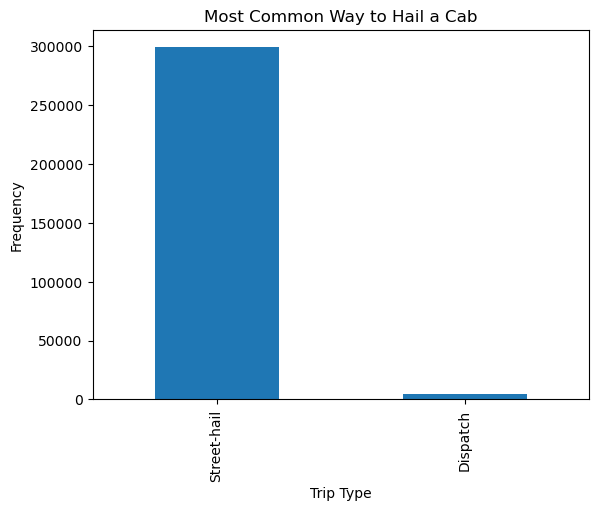

In [27]:
# Most common way that New Yorkers request/hail a cab
trip_type_counts = tripdata_df['trip_type'].value_counts()

# Convert the numeric values to text
trip_type_counts.index = trip_type_counts.index.map({1: 'Street-hail', 2: 'Dispatch'})

# Plot
trip_type_counts.plot(kind='bar', title='Most Common Way to Hail a Cab')
plt.xlabel('Trip Type')
plt.ylabel('Frequency')
plt.show()

This chart shows the most common way that New Yorkers request/hail a cab. It can be seen that street-hail is the most common way with over 350,000 observations.

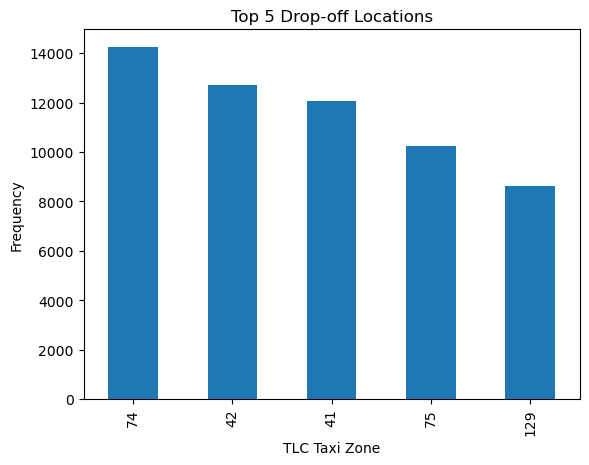

In [28]:
# The most common drop-off location (display the top 5 locatons)
top_five_dropoff = tripdata_df['DOLocationID'].value_counts().head(5)

# Plot the bar chart
top_five_dropoff.plot(kind='bar', title='Top 5 Drop-off Locations')
plt.xlabel('TLC Taxi Zone')
plt.ylabel('Frequency')
plt.show()

This chart shows the most common drop-off location, displaying the top 5 locations. It can be seen that TLC Taxi Zone 74 is the most common drop-off location with over 14,000 observations.

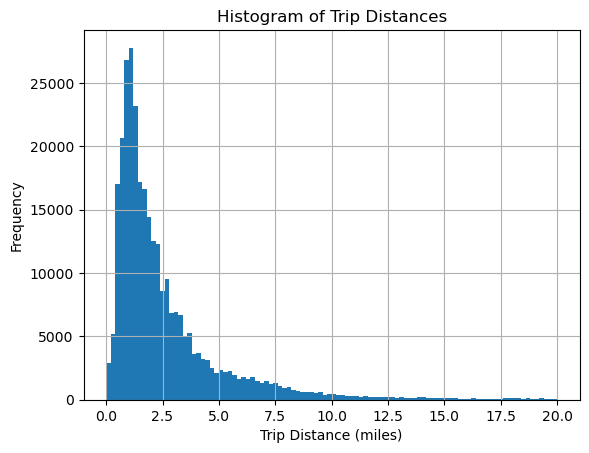

In [29]:
# Findings from analysis indicate that most customers use green taxis to travel short distances
# Ensuring filtering out any outlier trips

# Plot a histogram of trip distance to visualize the distribution
tripdata_df['trip_distance'].hist(bins=100, range=(0,20))
plt.title('Histogram of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

In [30]:
# Cutoff point for outlier trips
outlier_cutoff_point = 10

# Filter out outlier trips
tripdata_df = tripdata_df[tripdata_df['trip_distance'] <= outlier_cutoff_point]

Based on the histogram of trip distances it is evident that the frequency of trips decreases as the distance increases. The majority of trips appear to be under 5 miles. I selected a cutoff point of 10 miles to filter out long trips (or outliers) to ensure that I capture most of the typical trip distances. 

# Question 3 (5 pts)

Based on the insights from your EDA, select the required features to build your model and ensure that you encode any categorical variables. Briefly explain the reason for the features that you selected.
Remember that Data Science relies heavily on experimentation. Therefore, you are encouraged to experiment with your data.
- **Tip #1**: ensure that you carefully consider each feature. For example, the total_amount is a variable in your dataframe; however the total amount for each trip can also be obtained if you add all the charges for each passenger (e.g. fare_amount + extra + mta_tax + tip_amount + tolls_amount + improvement_surcharge + congestion_surcharge). Therefore, is it best to include the total_amount in your model or the breakdown that shows each individual charge? Think about the pros and cons of your decisions.
- **Tip #2**: you are predicting the **tip amount**, therefore it should not be one of your explanatory variables.

In [31]:
# Encode any categorical variables 
tripdata_df = pd.get_dummies(tripdata_df, columns=['VendorID', 'payment_type'], drop_first=True)

In [32]:
# Select the required features to build the model
features = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 
    'tolls_amount', 'improvement_surcharge', 'congestion_surcharge','VendorID_2', 
    'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5'
]

- `VendorID`: I selected this feature because the two different vendors might have different standards of service that could impact the `tip_amount`.
- `passenger_count`: I selected this feature because the number of passengers could influence the tip amount with a larger group possibly tipping higher.
- `trip_distance`: I selected this feature because longer trips may result in higher fares, which could lead to higher tips.
- `fare_amount`, `extra`, `mta_tax`, `tolls_amount`, `improvement_surcharge`, `congestion surcharge`: I selected these features to prevent data leakage. By excluding `total_amount` and using the breakdown of the charges for each passenger, the model cannot access direct information about the tip amount. Similarly, including these features such as `extra`, `tolls_amount`, and `congestion_surcharge`, the model can learn to predict the tip based on the complexity of the trip or the time of day. Thus, this allows the model to predict behavior based on various factors when deciding the tip, rather than just a direct fraction of the total cost. 
- `payment_type`: I selected this feature because the method of payment might influence a passenger's tip. For example, if a passenger pays with card they might be more likely to add a tip on the vehicle's payment system. 

# Question 4 (5 pts)

Partition the prepared data into train/test sets and ensure that your partitions are reproducible.

In [33]:
# Partition the data into train/test sets and ensure that partitions are reproducible
X = tripdata_df[features]
y = tripdata_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7  #reproduce the results
                                                   )

I split the dataset into training and testing subsets and used the `train_test_split` function to parition the dataset, with 70% used for training the model and 30% used for testing its performance. The random_state of 7 ensured that the split is reproducible. 

# Question 5 (10 pts)

Using the Random Forest algorithm, build a machine learning model that predicts **the tip amount**.

Think about the following: **Are you performing classification or regression?** Ensure that you choose the appropriate Random Forest Classifier/Regressor from scikit-learn.

In [34]:
# Using the Random Forest Algorithm, build a machine learning model that predicts the tip amount
forest = RandomForestRegressor(random_state=7)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=7)

In [35]:
# Predict the labels for the test set
y_pred = forest.predict(X_test)

# Print each predicted tip amount rounded to 2 decimal places (showing first 5)
for pred in y_pred[:5]:
    print(f'The predicted tip amount is: {pred:.2f}')

The predicted tip amount is: 2.34
The predicted tip amount is: 1.36
The predicted tip amount is: 1.14
The predicted tip amount is: 1.53
The predicted tip amount is: 2.91


For predicting the **tip amount**, which is a continuous variable, I used regression, specifically the `RandomForestRegressor`.

The printed output shows the predicted tip amounts for the first five trips in the test, rounded to 2 decimal places. 

# Question 6 (5 pts)

Evaluate the predictions from your model and comment on the results. Ensure that you choose the appropriate metric to evaluate the model and round your calculations to two decimal places. Remember that we evaluate models differently depending on the task, i.e. classification or regression.

In [36]:
# Evaluate the predictions from the model using the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(f'The MSE of the model is: {mse:.2f}')

The MSE of the model is: 2.22


I evaluated the predictions from the model using the Mean Squared Error (MSE). The MSE of 2.22 indicates that the estimated values (predicted tip amounts) and the actual value (actual tip amounts) are reasonably close, within a $2.22 range of the actual tip amounts.

# Question 7 (15 pts)

What are your thoughts on the model's prediction capability? Did it do a good job of predicting the tip_amount?
Note: it is okay if your first version of the model is not the best. However, there are strategies that we can use to improve it, such as tuning.
- Tune the model: you can control the number of trees in your forest using the n_estimators parameter. Refer to the sample code from the lecture and [also view the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to learn more about this algorithm and its parameters. **Try at least three different values for the n_estimators parameter to determine if the model improved**. Show all your steps to create, evaluate and tune each version of the model.
- Indicate which model performed the best.

In [37]:
# Calculate the range of the tip amounts
range = y_test.max() - y_test.min()

# Print the range
print(f"The range of the actual tip amounts is: {range:.2f}")

The range of the actual tip amounts is: 100.00


Based on the MSE of 2.22 in relation to the range of tip amounts, which is 100.00, the model appears to have a decent prediction capability for the tip amount. The MSE is quite low compared to the range, demonstrating that, on average, the model's tip predictions are close to the actual tip amounts. However, to fully assess the model's prediction capability, further analysis is necessary. 

In [38]:
# Tune the model using the n_estimators parameter (try at least 3 different values for the n_estimators paramater to determine if the model improved)
estimators = [50, 100, 200]
for n in estimators:
    forest = RandomForestRegressor(n_estimators=n, random_state=7)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'The MSE for n_estimators={n}: {mse:.2f}')

The MSE for n_estimators=50: 2.27
The MSE for n_estimators=100: 2.22
The MSE for n_estimators=200: 2.16


This demonstrates the MSE for each model with differing `n_estimators`. It is evident that increasing the number of trees in the forest decreases the MSE, demonstrating an improvement in the model's predictive capability. 

The model with `n_estimators=200` performed the best which can be seen with an MSE of 2.16. This shows that having more trees in the forest gives a more accurate prediction of the tip amount. 

# Question 8 (+5 bonus points) 

The Random forest has a method that returns the importance of each feature in your model. Review the documentation to learn about feature importance. After which, write the appropriate code that demonstrates which features were the most important when making the predictions. Demonstrate the feature importance using the best model and explain the results.

In [39]:
# Demonstrates which features were the most important when making the predictions using the best model
best_forest = RandomForestRegressor(n_estimators=200, random_state=7)
best_forest.fit(X_train, y_train)

# Get numerical feature importances
importances = list(best_forest.feature_importances_)

# List of tuples with variable and importance
feature_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

# Print out the feature and importances
for feature, importance in feature_importances:
    print(f'Variable: {feature:20} Importance: {importance:.2f}')

Variable: payment_type_2       Importance: 0.33
Variable: trip_distance        Importance: 0.27
Variable: fare_amount          Importance: 0.24
Variable: extra                Importance: 0.07
Variable: passenger_count      Importance: 0.03
Variable: VendorID_2           Importance: 0.03
Variable: congestion_surcharge Importance: 0.02
Variable: tolls_amount         Importance: 0.01
Variable: payment_type_3       Importance: 0.00
Variable: mta_tax              Importance: 0.00
Variable: payment_type_4       Importance: 0.00
Variable: improvement_surcharge Importance: 0.00
Variable: payment_type_5       Importance: 0.00


This demonstrates that the `payment_type_2` variable has the highest importance with a score of 0.33. This suggests that the way passengers choose to pay (in this case corresponding to cash payments) is the most significant predictor of the tip amount. The `trip_distance` and `fare_amount` are also very important because the longer the trip and the higher the fare, the higher the tip is. While `extra`, `passenger_count`, and `VendorID_2` have some influence, the rest of the features indicate little to no importance. 

**Resources**

For a more in depth understanding of random forests and feature importance, I referred to an article which can be found [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0).

## Helpful resources 
Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment inside the code cell, or you can list them below. 

You do not need to cite the official python documentation.
